Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests
from keras.callbacks import History 
history = History()

API_KEY = 'ei_93396b8ba0c6af98fbeaf2f8483d323b1b6f7de866f76527b07f66d584dc79bd'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/92758/training/8/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/92758/training/8/y')


2022-04-11 09:40:39.761933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 09:40:39.762048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Fire", "Safe" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


2022-04-11 09:41:42.878736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-11 09:41:42.879542: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 09:41:42.879670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-723B7MAA): /proc/driver/nvidia/version does not exist
2022-04-11 09:41:42.886858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model:

In [4]:
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy


WEIGHTS_PATH = './transfer-learning-weights/edgeimpulse/MobileNetV2.0_35.96x96.grayscale.bsize_64.lr_0_005.epoch_260.val_loss_3.10.val_accuracy_0.35.hdf5'
# Download the model weights
root_url = 'http://cdn.edgeimpulse.com/'
p = Path(WEIGHTS_PATH)
if not p.exists():
    if not p.parent.exists():
        p.parent.mkdir(parents=True)
    weights = requests.get(root_url + WEIGHTS_PATH[2:]).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights)

INPUT_SHAPE = (96, 96, 1)


base_model = tf.keras.applications.MobileNetV2(
    input_shape = INPUT_SHAPE, alpha=0.35,
    weights = WEIGHTS_PATH
)

base_model.trainable = False

model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))
# Don't include the base model's top layers
last_layer_index = -3
model.add(Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(Reshape((-1, model.layers[-1].output.shape[3])))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


# Set the data to the expected input shape
train_dataset = train_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)


BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=20, verbose=2, callbacks=callbacks)

print('')
print('Initial training done.', flush=True)

# How many epochs we will fine tune the model
FINE_TUNE_EPOCHS = 10
# What percentage of the base model's layers we will fine tune
FINE_TUNE_PERCENTAGE = 65

print('Fine-tuning model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# Determine which layer to begin fine tuning at
model_layer_count = len(model.layers)
fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# Allow the entire base model to be trained
model.trainable = True
# Freeze all the layers before the 'fine_tune_from' layer
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train_dataset,
                epochs=FINE_TUNE_EPOCHS,
                verbose=2,
                validation_data=validation_dataset,
                callbacks=callbacks,
                class_weight=None
            )


Epoch 1/20
83/83 - 12s - loss: 0.4165 - accuracy: 0.8096 - val_loss: 0.3046 - val_accuracy: 0.8803 - 12s/epoch - 143ms/step
Epoch 2/20
83/83 - 5s - loss: 0.2520 - accuracy: 0.8999 - val_loss: 0.2676 - val_accuracy: 0.8879 - 5s/epoch - 65ms/step
Epoch 3/20
83/83 - 6s - loss: 0.2121 - accuracy: 0.9185 - val_loss: 0.2589 - val_accuracy: 0.8955 - 6s/epoch - 75ms/step
Epoch 4/20
83/83 - 5s - loss: 0.1835 - accuracy: 0.9291 - val_loss: 0.2507 - val_accuracy: 0.9045 - 5s/epoch - 66ms/step
Epoch 5/20
83/83 - 5s - loss: 0.1655 - accuracy: 0.9352 - val_loss: 0.2534 - val_accuracy: 0.9030 - 5s/epoch - 59ms/step
Epoch 6/20
83/83 - 5s - loss: 0.1515 - accuracy: 0.9424 - val_loss: 0.2454 - val_accuracy: 0.9091 - 5s/epoch - 59ms/step
Epoch 7/20
83/83 - 5s - loss: 0.1426 - accuracy: 0.9484 - val_loss: 0.2386 - val_accuracy: 0.9076 - 5s/epoch - 61ms/step
Epoch 8/20
83/83 - 6s - loss: 0.1225 - accuracy: 0.9545 - val_loss: 0.2416 - val_accuracy: 0.9121 - 6s/epoch - 72ms/step
Epoch 9/20
83/83 - 8s - loss:

In [5]:
# Save the model to disk
model.save('saved_model')

2022-04-11 09:45:12.978634: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


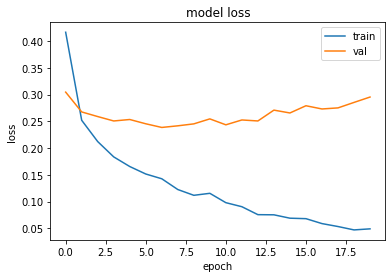

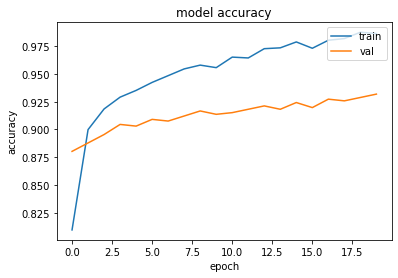

In [6]:
import keras
from matplotlib import pyplot as plt

loss=history.history['loss']
loss=loss[:20]
plt.plot(loss)
val_loss=history.history['val_loss']
val_loss=val_loss[:20]
plt.plot(val_loss)



plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

acc=history.history['accuracy']
acc=acc[:20]
plt.plot(acc)
vacc=history.history['val_accuracy']
vacc=vacc[:20]
plt.plot(vacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()